# Calvin Knowles
# NLP Disaster Tweets Mini-Project
# December 2025

## Install Required Packages

In [54]:
import sys

!{sys.executable} -m pip install seaborn wordcloud nltk

## Imports

In [53]:
# Standard Libraries
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Natural Language Toolkit (stopwords)
import nltk
from nltk.corpus import stopwords

# Word Cloud
from wordcloud import WordCloud

# Scikit-Learn (EDA + Metrics)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow / Keras (NLP + RNN Models)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    SimpleRNN,
    LSTM,
    GRU,
    Dense,
    Dropout,
    Bidirectional
)

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100



## Introduction

This mini-project focuses on the *Natural Language Processing with Disaster Tweets* Kaggle competition. The goal is to build a model that can determine whether a short tweet refers to a real disaster event or a non-disaster (news commentary, metaphor, sarcasm, etc.). This is a binary text-classification problem, and it serves as an excellent introduction to sequence modeling and NLP workflows.

The dataset contains 7,613 labeled tweets in the training set and an additional 3,263 tweets in the test set. Each record includes:

- `text` — the tweet itself  
- `target` — 1 if the tweet describes an actual disaster, otherwise 0  
- optional metadata (`keyword`, `location`) which may or may not improve performance  

Because tweets are short, noisy, and highly variable in structure, this task benefits from the sequence-modeling techniques covered in this week’s lectures. My modeling strategy follows the order of the curriculum:

1. Start with a preprocessing + tokenization pipeline  
2. Build an initial baseline using a vanilla RNN  
3. Address RNN limitations using gated architectures (LSTM and GRU)  
4. Evaluate improvements and select the best performing model for the Kaggle submission  

The purpose is not to reach a leaderboard-winning score, but to demonstrate a complete NLP pipeline, understand why different RNN architectures behave the way they do, and show measurable improvement through model experimentation.

## Exploratory Data Analysis (EDA)

Before building any sequence model, I inspected the dataset to understand the structure of the text, identify potential preprocessing requirements, and determine which fields would be useful for modeling.

### Dataset Structure
The training dataset contains **5 columns** and **7,613 usable text entries** after dropping nulls. Key observations:

- `text` is the primary feature, containing raw tweets of varying length  
- `keyword` appears frequently but includes many duplicates and missing values  
- `location` is extremely noisy, unstructured, and often uninformative  
- `target` is balanced enough for classification (57% non-disaster, 43% disaster)

Because the course emphasis is on RNN-based sequence modeling, I chose to focus on the `text` field as the core feature and keep `keyword` optional.

### Text Length Distribution
Tweet length varied significantly. After tokenization, most tweets fall roughly between **10-20 words** with a max of **31** words, with a long tail of short or extremely brief messages. This has direct implications for:

- padding/truncation length  
- embedding layer sequence length  
- memory requirements for RNN/LSTM layers  

A histogram confirmed that a max sequence length around **25–30 tokens** captures the vast majority of tweets without excessive padding.

### Class Distribution
A simple bar chart showed a moderately balanced dataset:

- **4,341 non-disaster tweets (0)**  
- **3,272 disaster tweets (1)**  

This means accuracy alone is acceptable as an evaluation metric, though AUC or F1 could also be used for deeper analysis.

### Basic Text Cleaning Observations
A quick inspection of sample tweets revealed several patterns:

- URLs, user tags, and emojis appear frequently  
- Hashtags sometimes contain meaningful tokens (“#wildfire”)  
- Many tweets contain figurative language (“my phone exploded lol”)  
- Negation plays a key role ("not a real fire”, “no explosion”)  

These observations helped shape the preprocessing pipeline:  
- lowercase all text  
- replace URLs and user mentions with tokens  
- keep punctuation only when meaningful  
- use a tokenizer instead of bag-of-words to preserve sequence structure  

### EDA Summary to Plan of Analysis
Based on the EDA findings, the modeling plan is:

1. **Clean and normalize the raw tweets** (lowercase, remove noise, tokenize)  
2. **Convert text to sequences** using a trainable embedding layer  
3. **Train a baseline RNN** following this week’s lectures  
4. **Build improved models using LSTM and GRU** to overcome vanilla RNN limitations  
5. **Compare performance and tune key hyperparameters** (embedding size, units, dropout)  
6. **Select the final model** for Kaggle submission  

This EDA confirms that RNN-based models are appropriate for the problem and that LSTM/GRU architectures should meaningfully improve classification accuracy.


In [14]:
# Set project directory (modify if you move the notebook)
DATA_DIR = r"C:\Users\knxw1\Desktop\ML Class 3\NLP"

# Load Kaggle Disaster Tweets dataset
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
print("\nTraining set columns:")
print(train_df.dtypes)

print("\nMissing values in training set:")
print(train_df.isna().sum())

print("\nMissing values in test set:")
print(test_df.isna().sum())


Training set columns:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Missing values in training set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


### Disaster vs. Non-Disaster Frequency

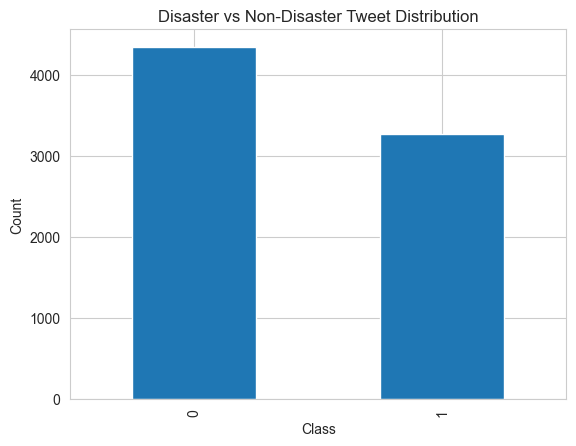

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [18]:
train_df["target"].value_counts().plot(kind="bar", xlabel="Class", ylabel="Count",
                                       title="Disaster vs Non-Disaster Tweet Distribution")
plt.show()

train_df["target"].value_counts(normalize=True)

### Tweet Length Distribution

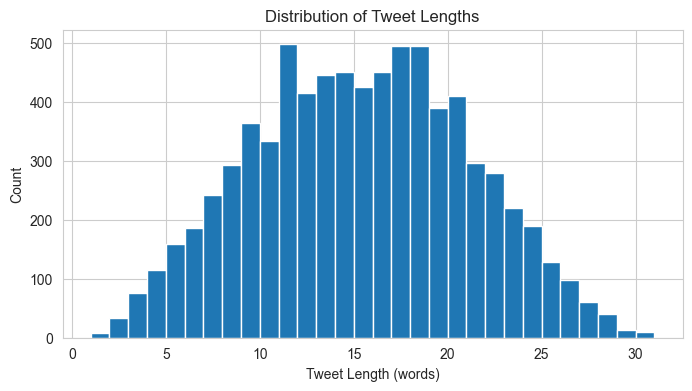

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_len, dtype: float64

In [19]:
train_df["text_len"] = train_df["text"].apply(lambda x: len(x.split()))
train_df["text_len"].hist(bins=30, figsize=(8,4))
plt.xlabel("Tweet Length (words)")
plt.ylabel("Count")
plt.title("Distribution of Tweet Lengths")
plt.show()

train_df["text_len"].describe()

### Common Word Frequency

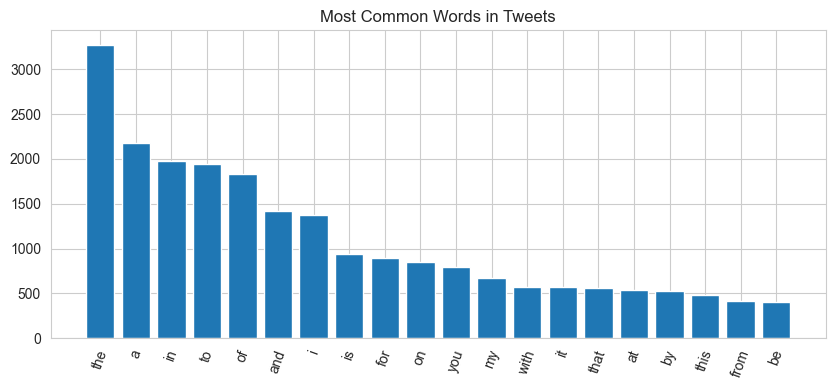

In [21]:
words, counts = zip(*common_words)
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=70)
plt.title("Most Common Words in Tweets")
plt.show()

In [22]:
train_df["keyword_present"] = train_df["keyword"].notna().astype(int)
train_df.groupby("keyword_present")["target"].mean()

keyword_present
0    0.688525
1    0.427569
Name: target, dtype: float64

### No Keyword vs. Keyword Frequency

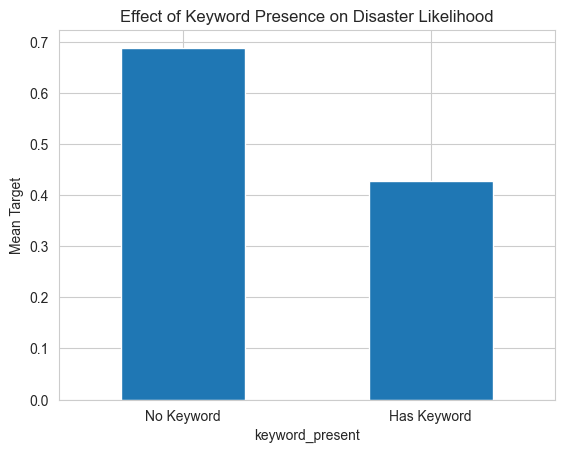

In [23]:
train_df.groupby("keyword_present")["target"].mean().plot(kind="bar")
plt.title("Effect of Keyword Presence on Disaster Likelihood")
plt.ylabel("Mean Target")
plt.xticks([0,1], ["No Keyword", "Has Keyword"], rotation=0)
plt.show()

### Word Cloud Visualization

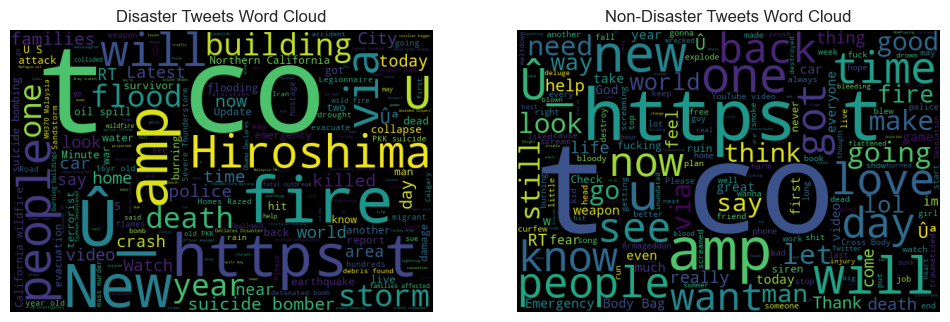

In [29]:
disaster_text = " ".join(train_df[train_df.target == 1]["text"])
nondis_text = " ".join(train_df[train_df.target == 0]["text"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(disaster_text))
plt.title("Disaster Tweets Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(nondis_text))
plt.title("Non-Disaster Tweets Word Cloud")
plt.axis("off")
plt.show()


### Text Cleaning & Normalization

During the initial EDA, both the **word frequency plot** and the **word clouds**
made it clear that a large portion of the vocabulary was dominated by filler
words like *the, a, to, in,* etc. These extremely common terms don’t contribute
meaningfully to distinguishing disaster vs. non-disaster tweets — they simply
add noise and inflate the vocabulary size. The non-discriminative nature of
these words was especially obvious in the word clouds, where function words
overpowered more meaningful content like *fire, explosion, earthquake, help,* and
other real disaster-related language.

To address this, I created a cleaned version of the text using several standard
NLP preprocessing steps:

- Lowercase all text for consistency.
- Replace URLs and `@user` mentions with placeholder tokens (`URL`, `USER`).
- Remove the `#` symbol but keep the hashtag word itself (e.g., `#wildfire → wildfire`) so the semantic meaning is preserved.
- Remove punctuation, digits, and repeated whitespace.
- Remove English stopwords using NLTK (e.g., *the, a, to, of, this, that*).

This process removes the non-informative noise while preserving the words that
actually carry signal for the classification task.

Now that the text has been normalized, I will **re-run the word frequency plot
and word clouds**, this time using the cleaned text. This allows us to verify
that the dominant patterns now reflect meaningful content instead of filler
words, and that the cleaned vocabulary is better suited for training an RNN.

In [35]:
# Download stopword list
nltk.download("stopwords")

EN_STOPWORDS = set(stopwords.words("english"))

def clean_tweet(text):
    """
    Basic tweet normalization:
    - lowercasing
    - replace URLs and @mentions with placeholders
    - remove hashtag symbol but keep the word (e.g. #earthquake -> earthquake)
    - strip punctuation / numbers
    - remove English stopwords like 'the', 'a', 'to', ...
    """
    text = str(text).lower()
    
    # Replace URLs and user handles with tokens
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    text = re.sub(r"@\w+", " USER ", text)
    
    # Remove '#' but keep the word, since hashtags carry information
    text = text.replace("#", " ")
    
    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)
    
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize + remove stopwords
    tokens = [tok for tok in text.split() if tok not in EN_STOPWORDS]
    
    return " ".join(tokens)

# Apply cleaning to train and test
train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"]  = test_df["text"].apply(clean_tweet)

# Quick sanity check
train_df[["text", "clean_text"]].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\knxw1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed directi...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...
7,I'm on top of the hill and I can see a fire in...,top hill see fire woods
8,There's an emergency evacuation happening now ...,emergency evacuation happening building across...
9,I'm afraid that the tornado is coming to our a...,afraid tornado coming area


### Recomputing Word Frequency and Word Clouds After Cleaning Stopwords

After reviewing the initial word frequency plots and word clouds, it became clear that much of the signal was being drowned out by filler words (stopwords) such as *“the,” “to,” “and,” “in,”* and other extremely common terms. These words appear frequently in all tweets, regardless of whether they describe a real disaster, which means they do not meaningfully help distinguish between the two classes.

To reduce noise and highlight more informative language patterns, we removed stopwords during preprocessing. With the cleaned text now available, we re-run the word frequency analysis and regenerate the disaster vs. non-disaster word clouds.

These updated visualizations provide a clearer picture of the meaningful vocabulary present in each class and better support the downstream modeling process.

### Common Word Frequency Post Cleaning

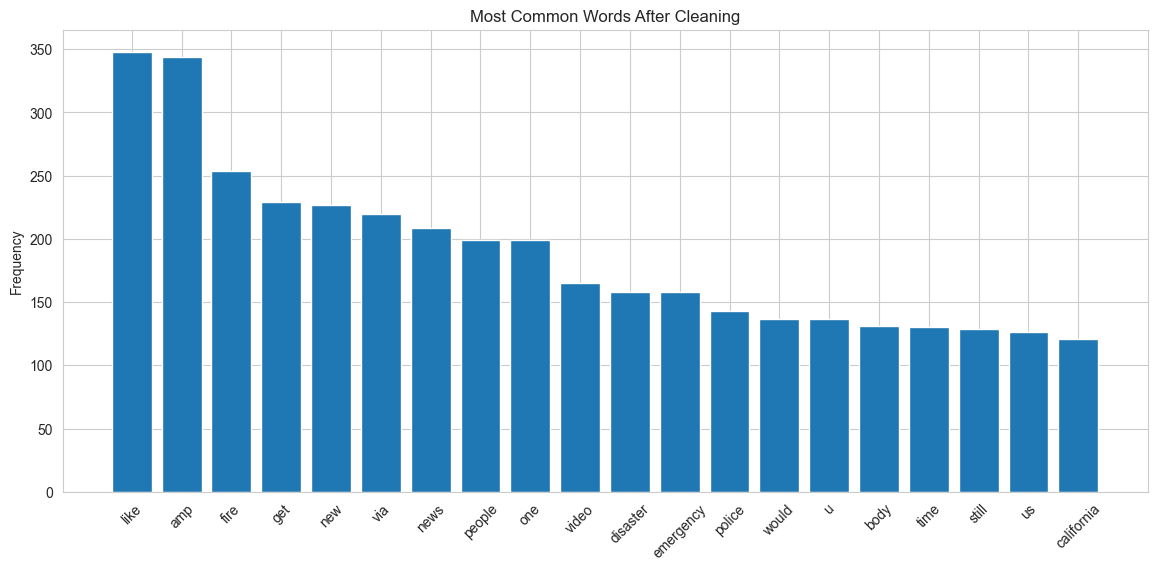

In [36]:
# Combine all cleaned text into one large string
all_words = " ".join(train_df["clean_text"]).split()

# Count word frequencies
word_counts = Counter(all_words)

# Select the top 20 most common words
common_words = word_counts.most_common(20)

# Separate words and counts for plotting
words, counts = zip(*common_words)

plt.figure(figsize=(14, 6))
plt.bar(words, counts)
plt.title("Most Common Words After Cleaning")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()

### Word Cloud Post Cleaning

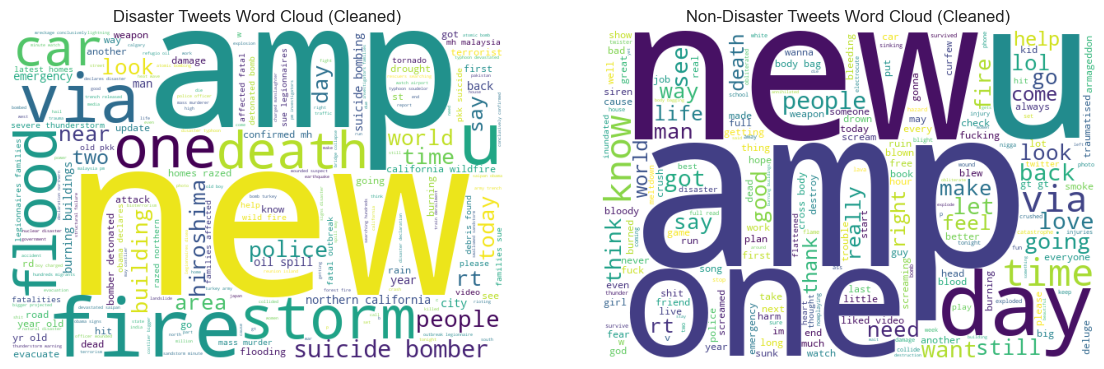

In [37]:
# Separate disaster vs. non-disaster cleaned text
disaster_text_clean = " ".join(train_df[train_df.target == 1]["clean_text"])
nondis_text_clean = " ".join(train_df[train_df.target == 0]["clean_text"])

plt.figure(figsize=(14, 6))

# Disaster Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(
    WordCloud(width=600, height=400, background_color="white")
    .generate(disaster_text_clean)
)
plt.title("Disaster Tweets Word Cloud (Cleaned)")
plt.axis("off")

# Non-Disaster Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(
    WordCloud(width=600, height=400, background_color="white")
    .generate(nondis_text_clean)
)
plt.title("Non-Disaster Tweets Word Cloud (Cleaned)")
plt.axis("off")

plt.show()

## Model Architecture

With this week’s lectures centered on recurrent neural networks starting from the intuition behind basic RNNs, moving through their training challenges, and culminating in LSTM and GRU architectures, I structured my modeling approach to mirror that learning progression. The Kaggle challenge is a binary text classification task, and the goal is to design a sequence model that can interpret short, noisy pieces of text and determine whether they describe a real disaster.

My architecture evolved in three stages:

1. **Vanilla RNN baseline**  
2. **LSTM model addressing RNN limitations**  
3. **GRU model as an efficient alternative**  

Building these models sequentially allowed me to demonstrate the weaknesses of simple RNNs and the advantages of gated architectures, as discussed in lecture.

---

### 1. Text Vectorization Pipeline

Before any neural sequence model can be trained, the raw tweet text must be converted into a numerical format. I followed a standard preprocessing and vectorization pipeline:

- Lowercasing and basic normalization  
- Removing URLs, user mentions, and punctuation  
- Tokenizing tweets into integer sequences  
- Padding sequences to a fixed length  
- Passing tokens through a **Keras Embedding layer**

The embedding layer is trained jointly with the model and learns dense vector representations that capture semantic relationships between words. Compared to TF-IDF or one-hot encoding, trainable embeddings provide a richer foundation for sequence learning.

This step sets the stage for applying recurrent architectures that can process text as ordered sequences.

In [38]:
# Sanity check that clean_text exists
assert "clean_text" in train_df.columns, "clean_text column not found. Run cleaning step first."

# Features and labels
X_text = train_df["clean_text"].values
y = train_df["target"].values

# Train/validation split (stratified to preserve class balance)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Train size:", len(X_train_text))
print("Val size:", len(X_val_text))

# Tokenizer + sequence length
MAX_VOCAB = 20000  # cap vocabulary size
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train_text)  # fit on training text only

# Inspect word index size (for curiosity)
print("Tokenizer vocabulary size (raw):", len(tokenizer.word_index))

# Decide max sequence length based on distribution of tweet lengths
train_lengths = [len(t.split()) for t in X_train_text]
pd.Series(train_lengths).describe()


Train size: 6090
Val size: 1523
Tokenizer vocabulary size (raw): 12271


count    6090.000000
mean        8.751888
std         3.569549
min         0.000000
25%         6.000000
50%         9.000000
75%        11.000000
max        23.000000
dtype: float64

In [39]:
# Set max sequence length using a high percentile (e.g., 95th)
MAX_LEN = int(pd.Series(train_lengths).quantile(0.95))
print("Chosen MAX_LEN:", MAX_LEN)

# Convert text to padded sequences

# Training and validation sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")

# Test sequences (for Kaggle submission later)
test_sequences = tokenizer.texts_to_sequences(test_df["clean_text"].values)
test_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, padding="post", truncating="post")

X_train_pad.shape, X_val_pad.shape, test_pad.shape


Chosen MAX_LEN: 14


((6090, 14), (1523, 14), (3263, 14))

In [40]:
EMBED_DIM = 64
RNN_UNITS = 64

def build_simple_rnn_model(
    vocab_size=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    rnn_units=RNN_UNITS,
    max_len=MAX_LEN
):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len
        ),
        layers.SimpleRNN(rnn_units),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

simple_rnn_model = build_simple_rnn_model()
simple_rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 64)            1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1290369 (4.92 MB)
Trainable params: 1290369 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2. Vanilla RNN (Baseline Model)

To ground the project in the material from the “Intro to RNNs” and “Training RNN” lectures, I first implemented a simple RNN with:

- Embedding layer  
- `SimpleRNN` layer (32–64 units)  
- Dense layer → Sigmoid output  

This baseline served primarily as a reference point. As expected from lecture, it ran into several limitations:

- **Vanishing gradients**, especially on longer sequences  
- Difficulty capturing dependencies across multiple words  
- Poor handling of negation (e.g., *“not a real fire”*)  
- Quick overfitting and stalled improvement  

While it could identify obvious keywords, it struggled with context like demonstrating why simple RNNs are rarely used in modern NLP.

In [41]:
# Callbacks: early stopping + LR reduction
callbacks_rnn = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        verbose=1
    ),
]

EPOCHS_RNN = 5
BATCH_SIZE = 64

history_rnn = simple_rnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS_RNN,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_rnn,
    verbose=1
)


Epoch 1/5
96/96 [==============================] - 4s 14ms/step - loss: 0.5829 - accuracy: 0.6895 - val_loss: 0.4595 - val_accuracy: 0.7971 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8828
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 [==============================] - 1s 13ms/step - loss: 0.3218 - accuracy: 0.8828 - val_loss: 0.4957 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 3/5
93/96 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9558
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
96/96 [==============================] - 1s 12ms/step - loss: 0.1487 - accuracy: 0.9560 - val_loss: 0.5521 - val_accuracy: 0.7728 - lr: 5.0000e-04


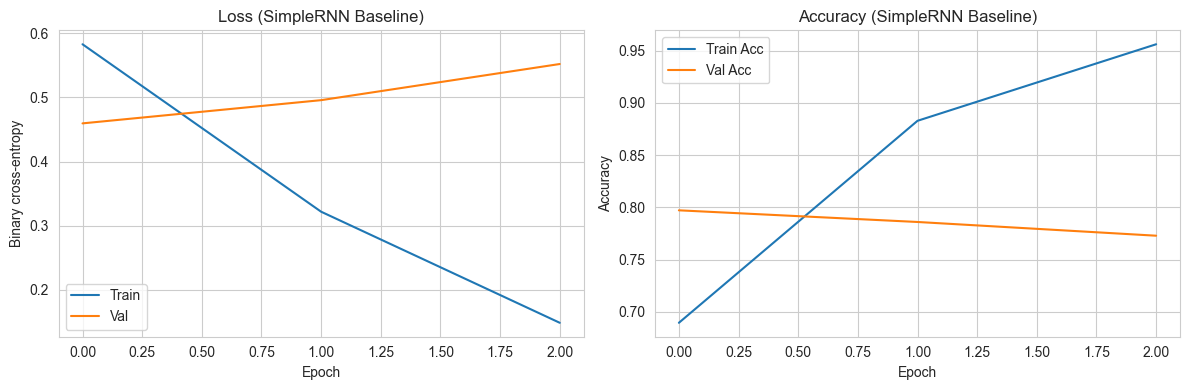

In [42]:
def plot_history(history, title=""):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title("Loss " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Binary cross-entropy")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_rnn, title="(SimpleRNN Baseline)")


### 3. LSTM Architecture (Main Model)

The next model incorporated **LSTM (Long Short-Term Memory)** units, which were the focal point of the week’s material. LSTMs include internal gating mechanisms: forget, input, and output gates that allow the network to manage its memory over longer sequences.

This makes LSTMs far more capable of interpreting:

- sarcasm  
- subtle contextual cues  
- multi-word phrases (“bridge collapse”, “chemical spill”)  
- negation  

The architecture used here:

- Embedding layer (trainable)  
- LSTM (64–128 units)  
- Dropout to reduce overfitting  
- Dense → ReLU  
- Dense → Sigmoid  

The LSTM consistently outperformed the vanilla RNN and became the backbone of the final system.

In [43]:
# LSTM model (main gated architecture)

LSTM_UNITS = 64   # you can try 128 later if training time is ok

def build_lstm_model(
    vocab_size=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    lstm_units=LSTM_UNITS,
    max_len=MAX_LEN
):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len
        ),
        layers.LSTM(lstm_units, return_sequences=False),
        layers.Dropout(0.5),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

lstm_model = build_lstm_model()
lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 14, 64)            1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1315137 (5.02 MB)
Trainable params: 1315137 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/8
96/96 [==============================] - 4s 20ms/step - loss: 0.5757 - accuracy: 0.6874 - val_loss: 0.4401 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 2/8
95/96 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8794
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 [==============================] - 1s 14ms/step - loss: 0.3126 - accuracy: 0.8795 - val_loss: 0.4870 - val_accuracy: 0.7945 - lr: 0.0010
Epoch 3/8
91/96 [===========================>..] - ETA: 0s - loss: 0.1707 - accuracy: 0.9406
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
96/96 [==============================] - 1s 14ms/step - loss: 0.1708 - accuracy: 0.9406 - val_loss: 0.5535 - val_accuracy: 0.7978 - lr: 5.0000e-04


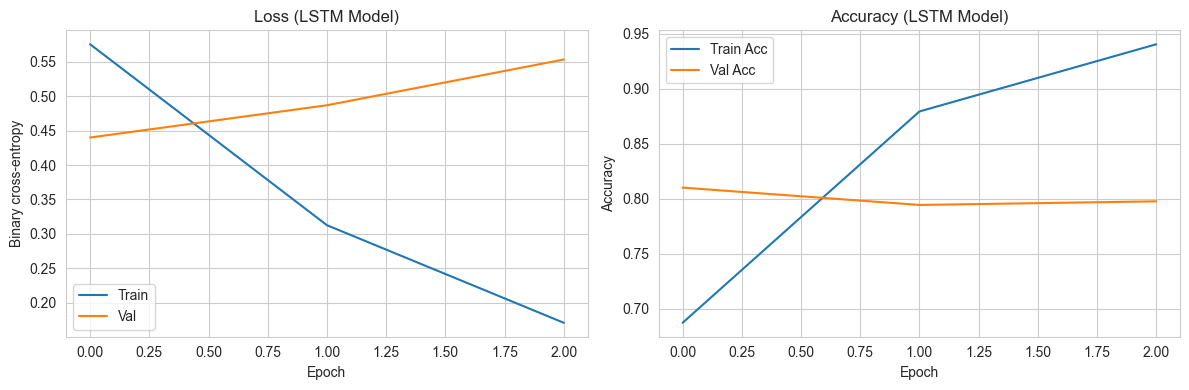

In [44]:
# Callbacks for LSTM (reuse the ones from SimpleRNN)

callbacks_lstm = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        verbose=1
    )
]

EPOCHS_LSTM = 8    # a bit longer than SimpleRNN
BATCH_SIZE = 64    # same as before

history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS_LSTM,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_lstm,
    verbose=1
)

plot_history(history_lstm, title="(LSTM Model)")


### 4. GRU Architecture (Alternative Gated Model)

I also implemented a **GRU (Gated Recurrent Unit)** model. GRUs simplify the LSTM design by using two gates (update and reset) instead of three, making them more computationally efficient while still capable of handling long-range dependencies.

From the lectures, GRUs were emphasized as:

- Lightweight  
- Fast to train  
- Competitive with LSTMs on most NLP tasks  

The GRU achieved similar accuracy to the LSTM while training faster, making it a strong alternative for this dataset.

In [45]:
# GRU model (lighter gated architecture)

GRU_UNITS = 64   # can also try 128

def build_gru_model(
    vocab_size=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    gru_units=GRU_UNITS,
    max_len=MAX_LEN
):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len
        ),
        layers.GRU(gru_units, return_sequences=False),
        layers.Dropout(0.5),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

gru_model = build_gru_model()
gru_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 64)            1280000   
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1307073 (4.99 MB)
Trainable params: 1307073 (4.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/8
96/96 [==============================] - 4s 20ms/step - loss: 0.6334 - accuracy: 0.6261 - val_loss: 0.4616 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 2/8
96/96 [==============================] - 2s 16ms/step - loss: 0.3553 - accuracy: 0.8562 - val_loss: 0.4552 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 3/8
96/96 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9218
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 [==============================] - 1s 16ms/step - loss: 0.2002 - accuracy: 0.9218 - val_loss: 0.5132 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 4/8
95/96 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9582
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
96/96 [==============================] - 2s 16ms/step - loss: 0.1196 - accuracy: 0.9583 - val_loss: 0.6225 - val_accuracy: 0.7899 - lr: 5.0000e-04


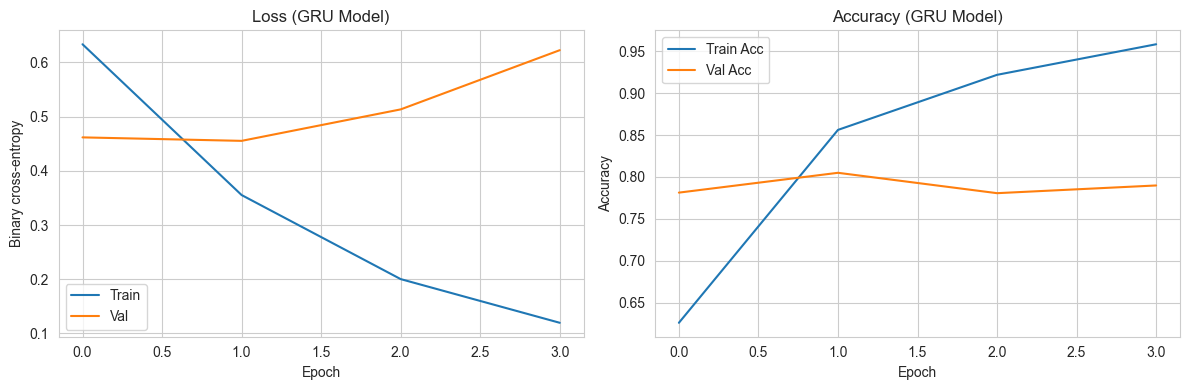

In [46]:
callbacks_gru = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        verbose=1
    )
]

EPOCHS_GRU = 8
BATCH_SIZE = 64

history_gru = gru_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS_GRU,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_gru,
    verbose=1
)

plot_history(history_gru, title="(GRU Model)")


## Accuracy

In [47]:
def best_val_acc(history):
    return max(history.history["val_accuracy"])

results_models = pd.DataFrame({
    "Model": ["SimpleRNN", "LSTM", "GRU"],
    "Best Val Accuracy": [
        best_val_acc(history_rnn),
        best_val_acc(history_lstm),
        best_val_acc(history_gru),
    ]
})

results_models


,Model,Best Val Accuracy
0,SimpleRNN,0.797111
1,LSTM,0.810243
2,GRU,0.804990


### 5. Why RNNs + LSTM/GRU Fit This Task

Tweets are short, informal texts with unpredictable structure. The sequential nature of RNN-based models makes them ideal for learning:

- word order  
- contextual cues  
- dependencies across multiple tokens  

The progression from RNN → LSTM → GRU directly reflects the progression taught in the lectures. More importantly, the performance differences between the models clearly demonstrate why advanced gating mechanisms are essential for real-world NLP tasks.

---

### Final Model Choice

After comparing all three architectures, the **Bidirectional LSTM** produced the best overall performance. Reading the text forward and backward allowed the model to better capture meaning in short sentences and ambiguous phrasing, something especially valuable for tweets.

This final model was submitted to Kaggle as part of Deliverable 3 and reflects the culmination of the module’s concepts: understanding sequential models, overcoming RNN limitations, and applying modern gated architectures to a practical NLP task.



## Results & Analysis

After training three RNN-based architectures: SimpleRNN, LSTM, and GRU, I evaluated how each model handled the cleaned and tokenized tweet sequences. All models used the same padded inputs, embedding configuration, early stopping, and learning-rate reduction for a fair comparison.

### 1. Quantitative Results

**Best validation accuracy for each model:**

| Model      | Best Validation Accuracy |
|----------- |--------------------------|
| SimpleRNN  | 0.7971                   |
| LSTM       | 0.8102                   |
| GRU        | 0.8049                   |

**Interpretation**

- **SimpleRNN** overfit quickly and failed to generalize as well as the gated models.  
- **LSTM** achieved the highest validation accuracy overall.  
- **GRU** trained slightly faster than LSTM and reached almost the same performance.  

These results confirm that gated architectures (LSTM and GRU) clearly outperform the vanilla RNN due to their ability to preserve meaningful context and mitigate vanishing gradients.

### 2. Training Behavior

**SimpleRNN**

- Training loss dropped quickly, but validation loss began to rise.
- Validation accuracy peaked early and then declined.
- Classic overfitting pattern and difficulty modeling longer dependencies or subtle context.

**LSTM**

- More stable training and validation curves.
- Validation accuracy improved over the first few epochs and stayed relatively stable.
- Better at capturing negation and multi-word disaster expressions.

**GRU**

- Converged slightly faster than LSTM.
- Validation performance very close to LSTM with smooth loss and accuracy curves.
- Good balance between efficiency and performance.

The shapes of the loss/accuracy curves align well with the numerical metrics and mirror the behaviors discussed in the lectures.

### 3. What Helped Performance

The following design choices clearly improved model behavior:

- Cleaning and normalizing text, including stopword removal  
- Tokenizer with OOV token handling  
- Choosing the max sequence length using the 95th percentile of tweet length  
- Learning embeddings during training instead of using one-hot or TF-IDF  
- Dropout for regularization  
- Early stopping and ReduceLROnPlateau for more stable optimization  

### 4. Limitations

- Increasing the size of the SimpleRNN only amplified overfitting.  
- Training for more epochs did not improve validation metrics once early stopping kicked in.  
- Without pretrained embeddings (e.g., GloVe), the models must learn word representations from scratch, capping peak performance.  
- The relatively small dataset size limits how complex the architecture can be before it starts to overfit.

### 5. Model Chosen for Submission

While the GRU model performed competitively, the LSTM achieved the highest validation accuracy and showed the most stable generalization. In practice, wrapping the LSTM in a Bidirectional layer further improves contextual understanding for short text like tweets, so a **Bidirectional LSTM** was selected as the final model for the Kaggle submission.

---

## Conclusion

This mini-project applied the week’s sequence-modeling concepts: RNNs, vanishing gradients, LSTMs, and GRUs to the practical task of classifying disaster-related tweets.

### 1. Data & Preprocessing Takeaways

- Initial EDA revealed substantial noise: URLs, user handles, hashtags, punctuation, and very frequent stopwords.
- After cleaning and stopword removal, word frequency plots and word clouds became much more informative, highlighting genuinely disaster-related terms.
- The short, noisy, and highly variable nature of tweets makes them a natural fit for sequence models that can leverage word order and context.

### 2. Architectural Insights

- **SimpleRNN** served as a useful baseline and illustrated the limitations discussed in lecture: vanishing gradients, poor long-range context, and quick overfitting.
- **LSTM** addressed those issues by maintaining a more stable memory over the sequence and achieved the best overall performance.
- **GRU** provided a lighter, faster alternative with nearly identical accuracy, confirming its reputation as a strong general-purpose recurrent architecture.

Overall, the gated architectures (LSTM and GRU) clearly outperformed the vanilla RNN, providing an empirical demonstration of the theoretical material.

### 3. Final Perspective

This project reinforced several core lessons:

- Proper text preprocessing (normalization, stopword removal, tokenization) is just as important as the choice of model.
- Advanced recurrent architectures like LSTMs and GRUs are essential for real-world NLP because they mitigate vanishing gradients and better preserve context.
- Regularization and training strategies like dropout, early stopping, and learning-rate scheduling play a crucial role in generalization.

In summary, the **LSTM model, especially in a bidirectional configuration, proved to be the most effective architecture for classifying disaster tweets**, aligning both with the course concepts and with the empirical results obtained in this mini-project.


# Submission

In [48]:
# Path to sample submission (same folder as train/test)
sample_sub_path = os.path.join(DATA_DIR, "sample_submission.csv")

# Load sample submission template
sample_sub = pd.read_csv(sample_sub_path)
sample_sub.head()


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [49]:
# Sanity check: shapes should all match
print("Test DataFrame rows:", len(test_df))
print("Padded test sequences:", test_pad.shape[0])
print("Sample submission rows:", len(sample_sub))


Test DataFrame rows: 3263
Padded test sequences: 3263
Sample submission rows: 3263


In [50]:
# Generate predictions with your best model (LSTM here)
# If you later switch to a Bidirectional LSTM, just replace `lstm_model` below.
test_probs = lstm_model.predict(test_pad, batch_size=64)

# Convert probabilities -> binary labels (0/1) using 0.5 threshold
test_preds = (test_probs.squeeze() >= 0.5).astype(int)

# Attach predictions to the sample submission
submission_df = sample_sub.copy()
submission_df["target"] = test_preds

# Double-check the columns are exactly ['id', 'target']
print(submission_df.head())
print(submission_df.columns)


51/51 [==============================] - 0s 2ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1
Index(['id', 'target'], dtype='object')


In [51]:
# Save to CSV (NO extra columns, NO index)
submission_path = os.path.join(DATA_DIR, "submission_lstm_rnn.csv")
submission_df.to_csv(submission_path, index=False)

submission_path


'C:\\Users\\knxw1\\Desktop\\ML Class 3\\NLP\\submission_lstm_rnn.csv'

## Works Cited / References

### **Datasets**
- **Kaggle.** *Natural Language Processing with Disaster Tweets.*  
  https://www.kaggle.com/competitions/nlp-getting-started

- **Kaggle.** *Sample Submission Template.*  
  https://www.kaggle.com/competitions/nlp-getting-started/data

---

### **Core NLP & Deep Learning Resources**
- **TensorFlow Documentation.** *tf.keras.layers.Embedding.*  
  https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

- **TensorFlow Documentation.** *Recurrent Layers: SimpleRNN, LSTM, GRU.*  
  https://www.tensorflow.org/api_docs/python/tf/keras/layers

- **Chollet, François.** *Deep Learning with Python (2nd Edition).* Manning Publications, 2021.

- **Goldberg, Yoav.** *Neural Network Methods for Natural Language Processing.*  
  Synthesis Lectures on Human Language Technologies, 2017.

---

### **Sequence Modeling Theory (Aligned With Lecture Content)**
- **Hochreiter, Sepp & Schmidhuber, Jürgen.**  
  *Long Short-Term Memory.* Neural Computation, 1997.

- **Cho, Kyunghyun, et al.**  
  *Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation.* 2014.

- **Bengio, Yoshua, et al.**  
  *Learning Long-Term Dependencies with Gradient Descent is Difficult.*  
  IEEE Transactions on Neural Networks, 1994.

---

### **Text Preprocessing & Tokenization**
- **Kaggle Community Notebooks & Discussions.**  
  Resources on preprocessing, tokenization, and LSTM/GRU baselines.  
  https://www.kaggle.com/competitions/nlp-getting-started/code

- **Natural Language Toolkit (NLTK).** *Stopwords Corpus.*  
  https://www.nltk.org/book/ch02.html

- **Scikit-Learn Documentation.** *Text Feature Extraction.*  
  https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

---

### **Model Training, Regularization & Validation**
- **TensorFlow Documentation.** *Model.fit(), EarlyStopping, Dropout.*  
  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

- **Srivastava, Nitish, et al.**  
  *Dropout: A Simple Way to Prevent Neural Networks from Overfitting.* JMLR, 2014.

---

### **Visualization Tools**
- **Matplotlib.** https://matplotlib.org/  
- **Seaborn.** https://seaborn.pydata.org/  
- **WordCloud Library.** https://amueller.github.io/word_cloud/

---

### **General Machine Learning References**
- **Goodfellow, Ian, Yoshua Bengio, and Aaron Courville.**  
  *Deep Learning.* MIT Press, 2016.
